In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import torchvision
from PIL import Image

from torchvision.datasets import VOCSegmentation
import random

In [2]:
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    DEVICE="cuda"
    print("Use CUDA")
else:
    DEVICE="cpu"

TRAIN = True

def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

Use CUDA


In [3]:
DATA_ROOT = "/kaggle/working/dataset"
VOC_YEAR = "2012"
LABELS = ["background", "aeroplane", "bicycle", "bird", "boat", "bottle",
          "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
          "motorbike", "person", "potted_plant", "sheep", "sofa", "train", "tv/monitor"]
MULTICLASS = False  # Если False, отделяем объекты от фона, иначе распознаем класс объектов.
NUM_CLASSES = len(LABELS) if MULTICLASS else 2
print("Number of classes:", NUM_CLASSES)

Number of classes: 2


In [4]:
valset_raw = VOCSegmentation(DATA_ROOT, VOC_YEAR, "val", download=True)

100%|██████████| 1999639040/1999639040 [01:12<00:00, 27453957.06it/s]


Extracting /kaggle/working/dataset/VOCtrainval_11-May-2012.tar to /kaggle/working/dataset


Mask values: {0, 8, 255}


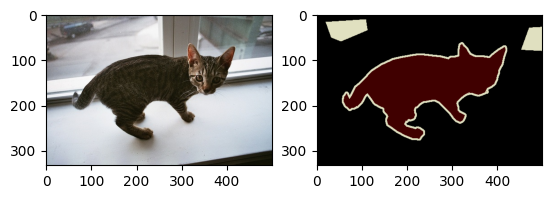

In [5]:
image, mask = valset_raw[random.randint(0, len(valset_raw) - 1)]
print("Mask values:", set(np.array(mask).flatten().tolist()))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

In [6]:
for _ in range(5):
    i = random.randint(0, len(valset_raw) - 1)
    print("Image {:05d} size: {}".format(i, valset_raw[i][0].size))

Image 00497 size: (500, 333)
Image 00463 size: (400, 300)
Image 00436 size: (342, 458)
Image 00746 size: (500, 375)
Image 01339 size: (500, 375)


In [7]:
class Scaler(object):
    """Отмасштабировать изображения сохранив пропорции.
    
    Пустые места будут заполнены отражениями.

    Аргументы:
        image: Изображение в HWC формате.
        size: Требуемый размер, пара W, H.
    """
    def __init__(self, size):
        self._size = size
        self._padding = 0
    
    def set_padding(self, padding):
        self._padding = padding
        
    def __call__(self, image):
        if not isinstance(image, np.ndarray):
            image = np.array(image)
        grayscale = (len(image.shape) == 2)
        if grayscale:
            image = image[..., None]
        rw, rh = self._size
        p = self._padding
        h, w, c = image.shape
        scale_x = rw / w
        scale_y = rh / h
        scale = min(scale_x, scale_y)
        sw = int(scale * w)
        sh = int(scale * h)
        offset_x = p + (rw - sw) // 2
        offset_y = p + (rh - sh) // 2
        # Используем zeros на случай маленьких изображений.
        result = np.zeros((rh + 2 * p, rw + 2 * p, c), dtype=image.dtype)
        cv2.resize(image, (sw, sh),
                   interpolation=cv2.INTER_NEAREST if grayscale else cv2.INTER_AREA,
                   dst=result[offset_y:offset_y + sh, offset_x:offset_x + sw])

        # Отразить.
        result[offset_y:offset_y + sh, :offset_x] = result[offset_y:offset_y + sh, offset_x:2 * offset_x][:, ::-1]
        offset_end = result.shape[1] - offset_x - sw
        result[offset_y:offset_y + sh, offset_x + sw:] = result[offset_y:offset_y + sh, sw + offset_x - offset_end:sw + offset_x][:, ::-1]
        
        result[:offset_y] = result[offset_y:2 * offset_y][::-1]
        offset_end = result.shape[0] - offset_y - sh
        result[offset_y + sh:] = result[sh + offset_y - offset_end:sh + offset_y][::-1]
        
        if grayscale:
            result = result[:, :, 0]
        return result

    
def remove_borders_inplace(mask):
    mask[mask == 255] = 0
    return mask
    

class VOCDataset(torch.utils.data.Dataset):
    """Обертка для стандартного класса, которая форматирует данные."""
    def __init__(self, root, year, image_size,
                 multiclass=MULTICLASS,
                 download=False, augment=False,
                 train=False, train_fraction=0.8,
                 padding=0):
        """Создать корпус.
        
        Аргументы:
            root: Путь до папки для хранения данных.
            year: 2007 или 2012.
            image_size: Ширина и высота изображений.
            download: Скачать корпус, если он не найден в папке.
            augment: Применить аугментации.
            train: Выделить train часть, иначе validation.
            train_fraction: Доля тренировочных примеров.
            padding: Добавить дополнительный зеркальынй паддинг к изображению.
        """
        self._dataset = VOCSegmentation(root, str(year), "trainval", download=download)
        self._image_size = np.array(image_size)
        self._multiclass = multiclass
        self._padding = padding
        
        ids = list(range(len(self._dataset)))
        random.seed(0)
        random.shuffle(ids)
        train_size = int(len(ids) * train_fraction)
        self._indices = ids[:train_size] if train else ids[train_size:]

        self._image_scaler = Scaler(image_size)
        self._mask_scaler = Scaler(image_size)
        if augment:
            self._augmenter = RandomAugmentation(AffineAugmenter(),
                                                 BrightnessContrastAugmenter(),
                                                 BlurAugmenter(),
                                                 FlipAugmenter())
        else:
            self._augmenter = lambda image, mask: (image, mask)
        
    @property
    def image_size(self):
        return self._image_size + self._padding * 2
    
    def set_padding(self, padding):
        self._padding = padding
        self._image_scaler.set_padding(padding)
        self._mask_scaler.set_padding(padding)
        
    def __len__(self):
        return len(self._indices)
    
    def __getitem__(self, idx):
        image, mask = self._dataset[self._indices[idx]]
        image = np.asarray(image)
        mask = np.array(mask)
        remove_borders_inplace(mask)
        if not self._multiclass:
            mask[mask > 0] = 1
        image = self._image_scaler(image)
        mask = self._mask_scaler(mask)
        image, mask = self._augmenter(image, mask)
        image = image_to_torch(image).float() - 0.5
        mask = image_to_torch(mask[..., None]).long()[0]
        return image, mask

IMAGE_SIZE = 512  # В исходной статье U-Net применяется к изображениям размера 572.

# Корпус был загружен выше, download = False.
trainset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                      multiclass=MULTICLASS, train=True)
valset = VOCDataset(DATA_ROOT, VOC_YEAR, (IMAGE_SIZE, IMAGE_SIZE),
                    multiclass=MULTICLASS, train=False)
print("Image size:", IMAGE_SIZE)
print("Train set size:", len(trainset))
print("Validation set size:", len(valset))

Image size: 512
Train set size: 2330
Validation set size: 583


In [8]:
def image_to_numpy(image):
    """Convert Torch tensor to Numpy image."""
    if isinstance(image, np.ndarray):
        return image
    if image.dtype == torch.float32:
        image = image - image.min()
        image = 255 * image / max(1e-6, image.max())
    return image.to(torch.uint8).permute(1, 2, 0).cpu().numpy()

def image_to_torch(image, device=None):
    """Convert Numpy image to Torch tensor."""
    if isinstance(image, torch.Tensor):
        return image
    if image.shape[-1] == 4:
        image = image[..., :3]
    result = torch.from_numpy(np.ascontiguousarray(image))
    if device is not None:
        result = result.to(device)
    result = result.permute(2, 0, 1)
    return result

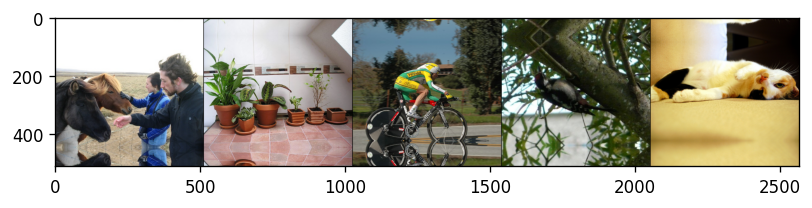

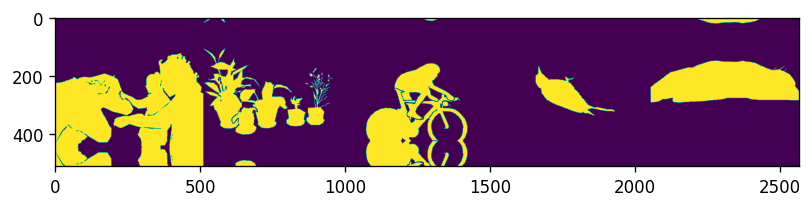

In [9]:
def show_dataset(dataset):
    images = []
    masks = []
    for _ in range(5):
        i = random.randint(0, len(valset) - 1)
        if len(images):
            separator = np.zeros((dataset.image_size[0], 2, 3), dtype=np.uint8)
            images.append(separator)
            masks.append(separator[:, :, 0])
        image, mask = dataset[i]
        images.append(image_to_numpy(image))
        masks.append(image_to_numpy(mask[None, ...])[..., 0])

    %matplotlib inline
    set_figure_size()
    plt.imshow(np.concatenate(images, axis=1))
    plt.show()
    set_figure_size()
    plt.imshow(np.concatenate(masks, axis=1))
    plt.show()
    
valset.set_padding(0)
show_dataset(trainset)

In [10]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp

In [11]:
def crop_images(predicted, masks_or_images):
    """Если выход больше или меньше чем исходное изображение,
    вырезать центральную часть из обоих, чтобы размеры совпадали.
    """
    if len(masks_or_images.shape) == 3:
        predicted, masks = crop_images(predicted, masks_or_images.unsqueeze(1))
        return predicted, masks[:, 0]
    images = masks_or_images
    if (len(predicted.shape) != 4) or (len(images.shape) != 4):
        raise ValueError("Expected tensors of shape BCHW")
    bi, ci, hi, wi = images.shape
    bp, cp, hp, wp = predicted.shape
    offset = (abs(hi - hp) // 2, abs(wi - wp) // 2)
    if hp < hi:
        images = images[:, :, offset[0]:offset[0] + hp]
    else:
        predicted = predicted[:, :, offset[0]:offset[0] + hi]
    if wp < wi:
        images = images[:, :, :, offset[1]:offset[1] + wp]
    else:
        predicted = predicted[:, :, :, offset[1]:offset[1] + wi]
    return predicted, images

In [12]:
class BCELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self._bce = torch.nn.BCEWithLogitsLoss()
        
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c != 1:
            raise ValueError("{} не подходит для многоклассовой классификации".format(type(self)))
            
        # predicted: float32, BCHW.
        # masks: long, BHW.
        loss = self._bce(predicted.squeeze(1), masks.float())
        return loss
       

In [13]:
class XentLoss(torch.nn.Module):
    """Функция потерь для сегментации с несколькими классами."""
    def __init__(self):
        super().__init__()
        self._xent = torch.nn.CrossEntropyLoss()
        
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c == 1:
            raise ValueError("{} не подходит для бинарной классификации".format(type(self)))
        predicted = predicted.permute(0, 2, 3, 1).reshape(b * h * w, c)
        masks = masks.reshape(-1)
        loss = self._xent(predicted, masks)
        return loss

In [14]:
class DiceLosswithBCE(torch.nn.Module):
    def __init__(self, smooth=1., eps=1e-6):
        super().__init__()
        self._bce = torch.nn.BCEWithLogitsLoss()
        self.smooth = smooth
        self.eps = eps
        
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        if c != 1:
            raise ValueError("{} не подходит для многоклассовой классификации".format(type(self)))
            
        # predicted: float32, BCHW.
        # masks: long, BHW.
        loss_bce = self._bce(predicted.squeeze(1), masks.float())
        
        predicted = torch.nn.functional.sigmoid(predicted).view(-1)
        masks = masks.view(-1)
        
        intersections = (predicted * masks).sum()
        unions = predicted.sum() + masks.sum()
        loss_dice = 1 - (2 * intersections + self.smooth)/(unions + self.smooth + self.eps)  
        return loss_bce + loss_dice
       

In [15]:
def make_optimizer(model, lr=1e-4):
    return torch.optim.AdamW(model.parameters(), lr=lr)

In [26]:
train_dataloader = torch.utils.data.DataLoader(
    trainset,
    shuffle=True,
    batch_size=16,
    )

val_dataloader = torch.utils.data.DataLoader(
    valset,
    shuffle=False,
    batch_size=16,
    )

In [17]:
def mean_iou(predictions, gt_labels):
    eps = 1e-5
    num_classes = predictions.shape[1]
    predictions, gt_labels = predictions.to("cpu"), gt_labels.to("cpu")
    predictions = (torch.nn.functional.sigmoid(predictions) > 0.5).long()
    mean_iou = 0.0
    for cls_ in range(1, num_classes + 1):
        match = (predictions[:, cls_ - 1, :, :] == 1)
        gt_match = (gt_labels == cls_)
        TP = (match & gt_match).sum()
        FP = (match & (~gt_match)).sum()
        FN = ((~match) & gt_match).sum()
        IoU = TP / (TP + FP + FN + eps) 
        mean_iou += IoU
    mean_iou /= num_classes
    return mean_iou



def train(model, dataloader, optimizer, loss_fn, epoch):
    model.train()
    for ind, batch in enumerate(dataloader):
        image, gt_mask = batch[0].to(DEVICE), batch[1].to(DEVICE)
        output = model(image)
        loss = loss_fn(output, gt_mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        wandb.log(
        {
            "train_loss": loss,
            "train_epoch": epoch,
        })

def validate(model, dataloader, loss_fn, epoch):
    model.eval()
    sum_losses = 0
    arr_of_iou_per_class = []
    with torch.no_grad():
        for ind, batch in enumerate(dataloader):
            image, gt_mask = batch[0].to(DEVICE), batch[1].to(DEVICE)
            output = model(image)
            loss = loss_fn(output, gt_mask)
            sum_losses += loss.item()
            arr_of_iou_per_class.append(mean_iou(output, gt_mask))
            
            wandb.log(
            {
                "val_loss": loss,
                "val_epoch": epoch,
            })
    mean_loss = sum_losses / len(dataloader)
    print(torch.Tensor(arr_of_iou_per_class))
    mean_IOU = torch.Tensor(arr_of_iou_per_class).mean()
    
    wandb.log(
    {
        "current_mean_val_loss": mean_loss,
        "mean_iou": mean_IOU,
    })
    print("mean_loss", mean_loss)
    print("mean_iou", mean_IOU, end='\n\n')

In [18]:
def start_training(model, train_dataloader, val_dataloder, loss_fn, num_epochs, lr):
    optimizer = make_optimizer(model, lr)
    loss_fn = loss_fn()
    for epoch in range(1, num_epochs + 1):
        train(model, train_dataloader, optimizer, loss_fn, epoch)
        validate(model, val_dataloder, loss_fn, epoch)

In [19]:
from kaggle_secrets import UserSecretsClient
import wandb
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb")
wandb.login(key=wandb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [20]:
model = smp.FPN(
    encoder_name="resnet18",
    encoder_weights=None,
    classes=NUM_CLASSES if NUM_CLASSES > 2 else 1)
model = model.to(DEVICE)

wandb.init(project="segmentation_VOC",)
loss_fn = BCELoss
wandb.config = {"epochs": 5,
                "loss": "BCELoss",
                "batch_size": 64,
                "encoder_name": "resnet18",
                "pretrain": "None",
                "lr": 1e-4,
                }
start_training(model, train_dataloader, val_dataloader, loss_fn, 10, 1e-4)
wandb.finish()

wandb: Currently logged in as: mishaya. Use `wandb login --relogin` to force relogin


tensor([0.1802, 0.1791, 0.1869, 0.1525, 0.1355, 0.1701, 0.1581, 0.1641, 0.1804,
        0.1517])
mean_loss 0.4631157755851746
mean_iou tensor(0.1658)

tensor([0.3038, 0.3015, 0.3114, 0.2596, 0.2740, 0.2767, 0.2886, 0.2818, 0.2868,
        0.4364])
mean_loss 0.4277967482805252
mean_iou tensor(0.3021)

tensor([0.2531, 0.2809, 0.2654, 0.2078, 0.2212, 0.2212, 0.2316, 0.2208, 0.2292,
        0.3426])
mean_loss 0.4199134409427643
mean_iou tensor(0.2474)

tensor([0.4176, 0.3755, 0.3755, 0.3329, 0.3307, 0.3325, 0.3471, 0.3517, 0.3468,
        0.4615])
mean_loss 0.387216517329216
mean_iou tensor(0.3672)

tensor([0.3464, 0.3063, 0.2979, 0.2555, 0.2733, 0.2539, 0.2971, 0.2983, 0.2806,
        0.4701])
mean_loss 0.4018162488937378
mean_iou tensor(0.3079)

tensor([0.4175, 0.3236, 0.3264, 0.2748, 0.2721, 0.2610, 0.3063, 0.3093, 0.3053,
        0.4094])
mean_loss 0.3954584926366806
mean_iou tensor(0.3206)

tensor([0.3961, 0.3778, 0.3672, 0.3602, 0.3242, 0.3482, 0.3344, 0.3009, 0.3391,
        0.4040]

current_mean_val_loss,▇▄▄▁▂▂▅▆▄█
mean_iou,▁▆▄█▆▆█▁▃▂
train_epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss,█▆▅▄▄▃▃▄▃▄▂▄▃▃▂▂▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▁▂▁▁▂▁▁
val_epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
val_loss,▃▃▅▄▂▃▄▃▂▃▄▃▁▄▃▃▂▅▃▃▁▅▃▃▃▄▆▄▄▇▆▅▃▅▅▄▅█▇▂
current_mean_val_loss,0.47317
mean_iou,0.20252
train_epoch,10
train_loss,0.34099
val_epoch,10


In [21]:
model = smp.FPN(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    classes=NUM_CLASSES if NUM_CLASSES > 2 else 1)
model = model.to(DEVICE)

wandb.init(project="segmentation_VOC",)
loss_fn = BCELoss
wandb.config = {"epochs": 5,
                "loss": "BCELoss",
                "batch_size": 64,
                "encoder_name": "resnet18",
                "pretrain": "imagenet",
                "lr": 1e-4,
                }
start_training(model, train_dataloader, val_dataloader, loss_fn, 5, 1e-4)
wandb.finish()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.3MB/s]


tensor([0.6075, 0.5716, 0.5318, 0.5825, 0.5664, 0.6269, 0.5938, 0.5824, 0.5637,
        0.5773])
mean_loss 0.29163058251142504
mean_iou tensor(0.5804)

tensor([0.6611, 0.5937, 0.5596, 0.5852, 0.5927, 0.6511, 0.6166, 0.6359, 0.5705,
        0.6382])
mean_loss 0.23623726963996888
mean_iou tensor(0.6105)

tensor([0.6646, 0.6020, 0.5757, 0.6016, 0.6039, 0.6516, 0.6459, 0.6447, 0.5879,
        0.6506])
mean_loss 0.2343378633260727
mean_iou tensor(0.6228)

tensor([0.6777, 0.6215, 0.5971, 0.6304, 0.6162, 0.7023, 0.6471, 0.6460, 0.6228,
        0.6184])
mean_loss 0.24319455176591873
mean_iou tensor(0.6379)

tensor([0.6951, 0.6285, 0.5969, 0.6311, 0.6231, 0.6737, 0.6521, 0.6594, 0.5949,
        0.6886])
mean_loss 0.23971550166606903
mean_iou tensor(0.6443)



current_mean_val_loss,█▁▁▂▂
mean_iou,▁▄▆▇█
train_epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,█▆▄▅▄▅▄▄▄▂▃▃▂▃▃▃▂▂▂▃▂▂▃▃▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁
val_epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
val_loss,▄▆▇█▄▇▆▇▁▄▅▆▂▄▂▅▁▅▅▆▃▃▂▄▁▅▅▇▂▄▃▄▁▅▆▇▃▄▂▁
current_mean_val_loss,0.23972
mean_iou,0.64435
train_epoch,5
train_loss,0.14813
val_epoch,5


In [22]:
model = smp.FPN(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    classes=NUM_CLASSES if NUM_CLASSES > 2 else 1)
model = model.to(DEVICE)
wandb.init(project="segmentation_VOC",)
loss_fn = DiceLosswithBCE
wandb.config = {"epochs": 5,
                "loss": "DiceLosswithBCE",
                "batch_size": 64,
                "encoder_name": "resnet18",
                "pretrain": "imagenet",
                "lr": 1e-4,
                }
start_training(model, train_dataloader, val_dataloader, loss_fn, 5, 1e-4)
wandb.finish()

tensor([0.6328, 0.5684, 0.5517, 0.5695, 0.5781, 0.5995, 0.6041, 0.5929, 0.5560,
        0.5987])
mean_loss 0.5872066527605057
mean_iou tensor(0.5852)

tensor([0.6571, 0.6043, 0.5836, 0.6255, 0.5979, 0.6626, 0.6289, 0.6233, 0.5862,
        0.6513])
mean_loss 0.5384815752506256
mean_iou tensor(0.6221)

tensor([0.6781, 0.5943, 0.5733, 0.6401, 0.6224, 0.6559, 0.6315, 0.6457, 0.5938,
        0.6947])
mean_loss 0.5253513604402542
mean_iou tensor(0.6330)

tensor([0.6758, 0.6201, 0.6075, 0.6294, 0.6324, 0.6897, 0.6476, 0.6515, 0.6169,
        0.6849])
mean_loss 0.5206908315420151
mean_iou tensor(0.6456)

tensor([0.7039, 0.6318, 0.6125, 0.6358, 0.6293, 0.6796, 0.6516, 0.6585, 0.6039,
        0.7188])
mean_loss 0.5197874695062638
mean_iou tensor(0.6526)



current_mean_val_loss,█▃▂▁▁
mean_iou,▁▅▆▇█
train_epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,█▆▄▅▄▄▄▄▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁
val_epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
val_loss,▄▇██▆▆▅█▃▅▇▆▃▅▄▆▂▆█▅▄▄▃▇▂▅▆▇▃▄▃▆▁▅▇▆▄▄▃▁
current_mean_val_loss,0.51979
mean_iou,0.65257
train_epoch,5
train_loss,0.32808
val_epoch,5


In [27]:
model = smp.FPN(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    classes=NUM_CLASSES if NUM_CLASSES > 2 else 1)
model = model.to(DEVICE)
wandb.init(project="segmentation_VOC",)
loss_fn = DiceLosswithBCE
wandb.config = {"epochs": 5,
                "loss": "DiceLosswithBCE",
                "batch_size": 16,
                "encoder_name": "resnet18",
                "pretrain": "imagenet",
                "lr": 1e-4,
                }
start_training(model, train_dataloader, val_dataloader, loss_fn, 5, 1e-4)
wandb.finish()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s] 


tensor([0.6520, 0.6544, 0.7064, 0.7183, 0.6646, 0.6392, 0.6817, 0.5851, 0.5641,
        0.6616, 0.5628, 0.6171, 0.6238, 0.6676, 0.5475, 0.6320, 0.6953, 0.5534,
        0.6232, 0.6989, 0.6953, 0.7364, 0.6202, 0.6409, 0.7844, 0.6540, 0.5221,
        0.6371, 0.7131, 0.5935, 0.6003, 0.5911, 0.6506, 0.6736, 0.5225, 0.6674,
        0.6617])
mean_loss 0.5188064446320405
mean_iou tensor(0.6409)

tensor([0.6859, 0.6592, 0.6011, 0.6934, 0.6146, 0.6090, 0.7342, 0.7088, 0.6029,
        0.6918, 0.5744, 0.5691, 0.7110, 0.6888, 0.4886, 0.6877, 0.6861, 0.6143,
        0.6540, 0.6293, 0.6968, 0.7807, 0.7396, 0.6014, 0.7880, 0.6371, 0.5339,
        0.6594, 0.6186, 0.6265, 0.6365, 0.7074, 0.7016, 0.6978, 0.5565, 0.5821,
        0.6602])
mean_loss 0.4888906293624156
mean_iou tensor(0.6521)

tensor([0.7354, 0.7045, 0.6469, 0.7244, 0.6017, 0.5820, 0.7622, 0.5267, 0.5980,
        0.6732, 0.5360, 0.6521, 0.6909, 0.6988, 0.5045, 0.6809, 0.7084, 0.5818,
        0.6044, 0.5984, 0.6876, 0.7236, 0.6729, 0.6217, 0.

current_mean_val_loss,▇▄█▃▁
mean_iou,▁▂▂▅█
train_epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss,█▆▅▄▄▄▄▅▅▃▃▂▃▃▄▂▃▃▂▂▂▃▂▃▄▂▂▂▂▂▂▃▁▁▁▁▁▁▂▁
val_epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
val_loss,▄▄▃▅▄▄▅▄▃▃▅▇▃▂▄▆▃▆▄▄▆▅▅▅▂▃▃▂▃▃▃█▂▄▃▂▁▃▄▃
current_mean_val_loss,0.45273
mean_iou,0.69475
train_epoch,5
train_loss,0.27438
val_epoch,5


# Show images

In [28]:
def show_segmentations(model, dataset, n=5):
    model.eval()
    if USE_CUDA:
        model.cuda()
    for _ in range(n):
        image, mask_gt = dataset[random.randint(0, len(dataset) - 1)]
        if USE_CUDA:
            image = image.cuda()
            mask_gt = mask_gt.cuda()
        with torch.no_grad():
            predicted = model(image.unsqueeze(0))[0]  # CHW.
            predicted, image = crop_images(predicted.unsqueeze(0), image.unsqueeze(0))
            predicted, image = predicted[0], image[0]
            c = predicted.shape[0]
            if c == 1:
                predicted = torch.nn.functional.logsigmoid(predicted)
                aggregated = predicted[0]
                predicted_labels = predicted[0] > np.log(0.5)
            else:
                predicted = torch.nn.functional.log_softmax(predicted, 0)
                aggregated = torch.logsumexp(predicted[1:], axis=0)
                predicted_labels = predicted.max(0)[1]
        aggregated = aggregated.cpu().numpy()
        predicted_labels = predicted_labels.cpu().numpy().astype(np.uint8)
        image = image_to_numpy(image)
        mask = (predicted_labels > 0)[..., None]
        selected = image * mask + 255 * (1 - mask)

        %matplotlib inline
        if c != 1:
            print("Classes:", [LABELS[i] for i in set(predicted_labels.flatten().tolist())])
        set_figure_size()
        fig, axs = plt.subplots(1, 4, figsize=(12, 6))
        axs[0].imshow(image)
        axs[1].imshow(predicted_labels)
        axs[2].imshow(aggregated)
        axs[3].imshow(selected)
        plt.show()

Trainset


<Figure size 960x720 with 0 Axes>

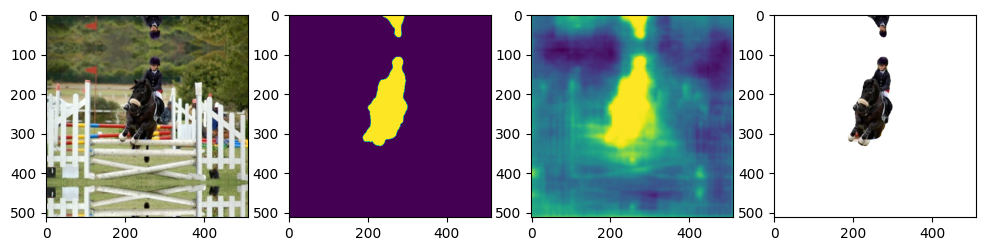

<Figure size 960x720 with 0 Axes>

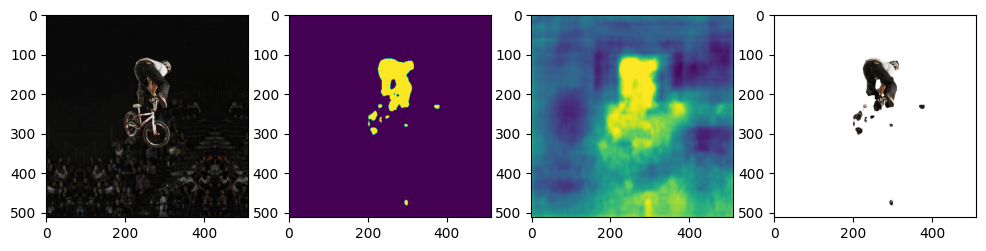

<Figure size 960x720 with 0 Axes>

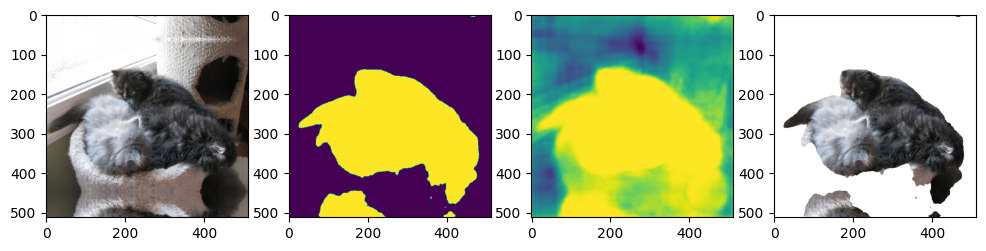

<Figure size 960x720 with 0 Axes>

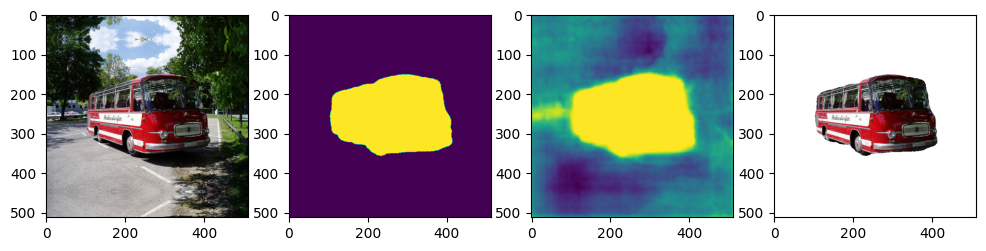

<Figure size 960x720 with 0 Axes>

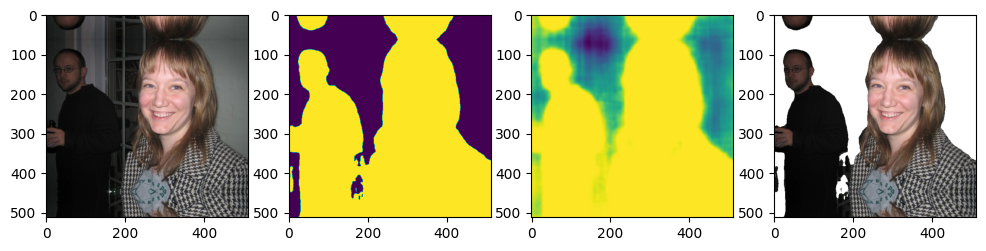

Valset


<Figure size 960x720 with 0 Axes>

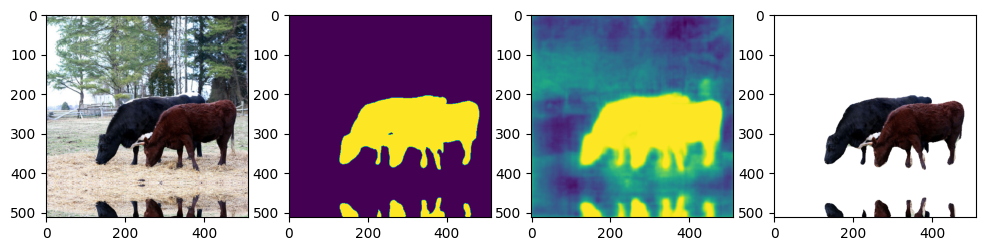

<Figure size 960x720 with 0 Axes>

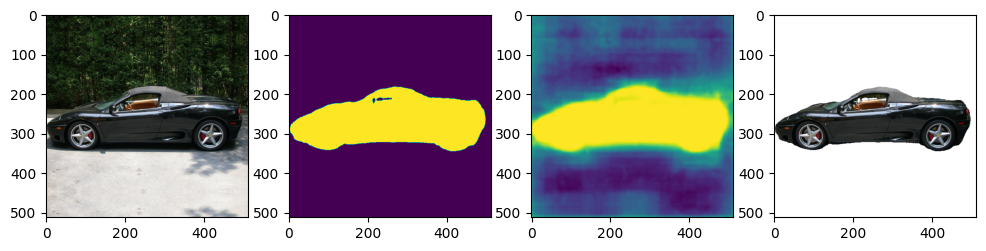

<Figure size 960x720 with 0 Axes>

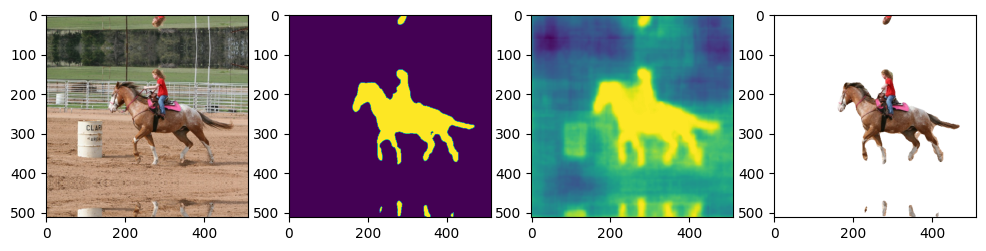

<Figure size 960x720 with 0 Axes>

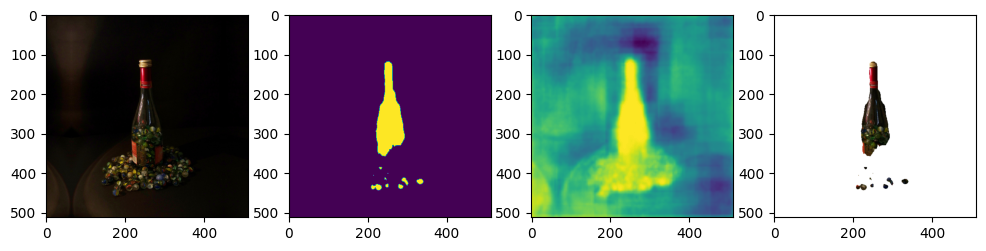

<Figure size 960x720 with 0 Axes>

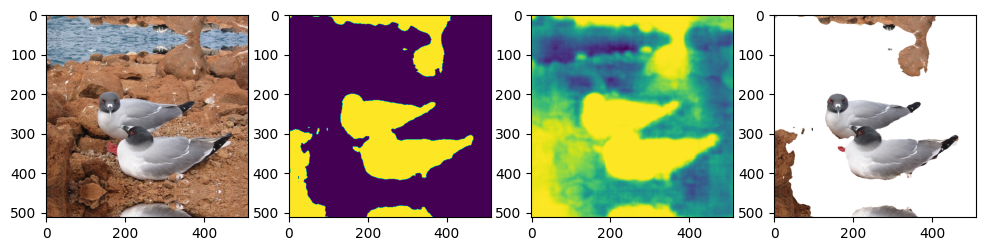

In [29]:
print("Trainset")
show_segmentations(model, trainset)

print("Valset")
show_segmentations(model, valset)

# Выводы

Модель FPN - http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf

Доска [wandb](https://wandb.ai/mishaya/segmentation_VOC?nw=nwusermishaya)

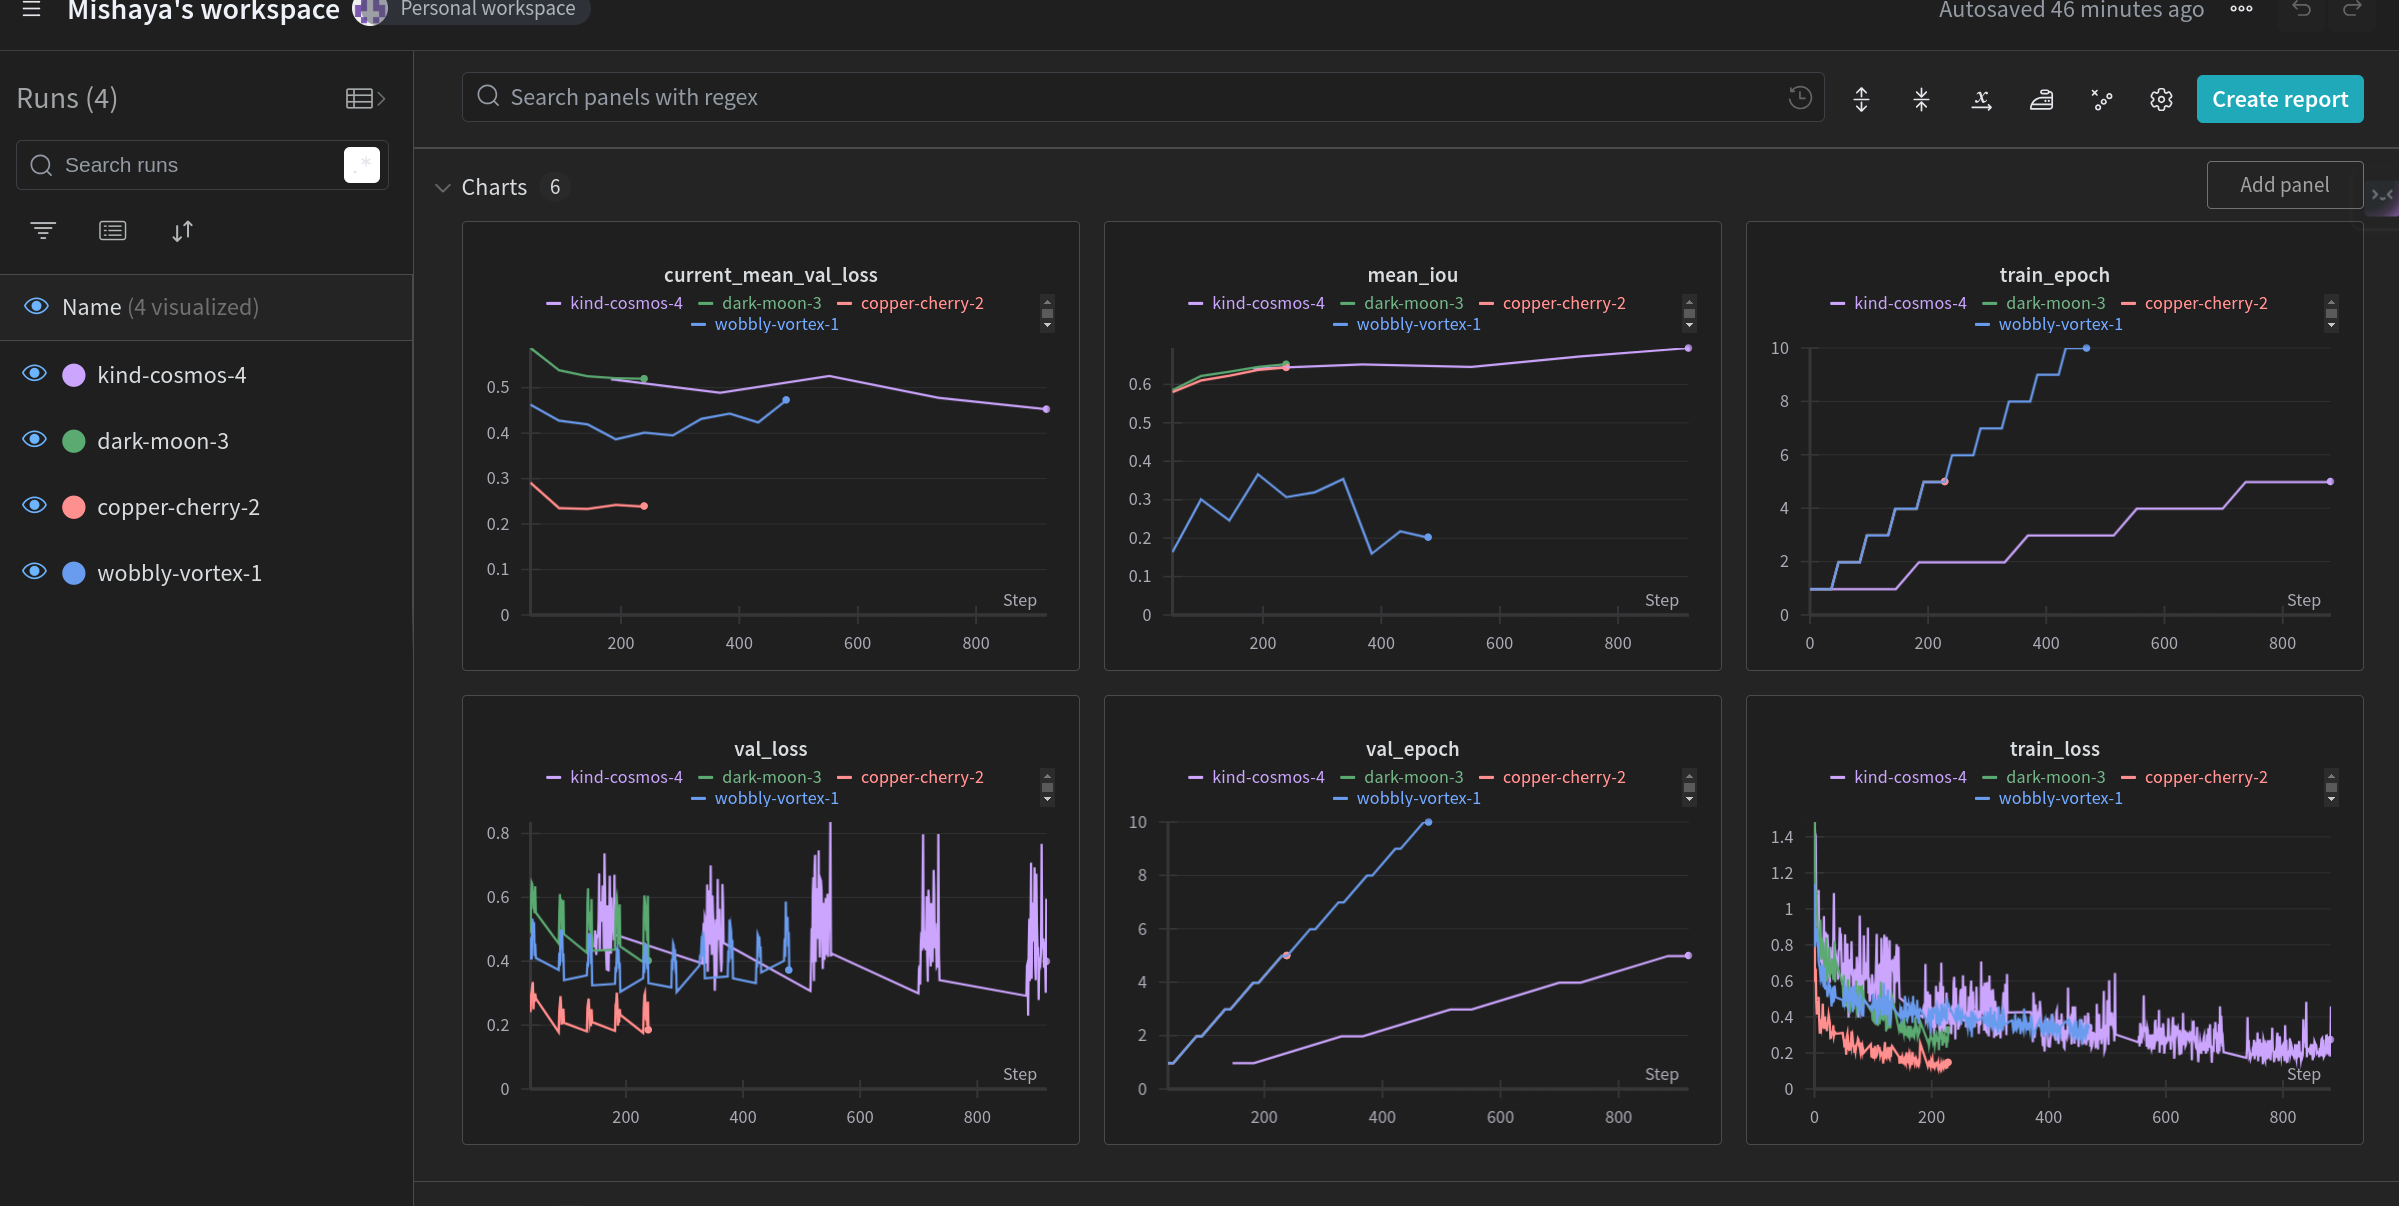

* wobbly-vortex-1 была обучена с рандомными весами, данная модель смогла достичь качества mean_IOU=0.36 (использовался BCELoss)

* copper-cherry-2 была обучена с прдобученными весами, данная модель смогла достичь качества   mean_IOU=0.64 (использовался BCELoss)

* dark-moon-3 была обучена с прдобученными весами, данная модель смогла достичь качества   mean_IOU=0.65 (использовался DiceLosswithBCE)

* kind-cosmos-4 была обучена с прдобученными весами, данная модель смогла достичь качества   mean_IOU=0.69 (использовался DiceLosswithBCE), в отличии от 3 запуска использовался энкодер resnet50

Для первых 3 моделей испольщовался энкодер resnet18
Энкодер сильно влияет на качество модели, нужно исследовать другие архитектуры энкодеров, так же функция потерь позволяет улучшить качество